## Abstract

In this notebook the performance of the reinforcement learning agent is compared with the human-managed inventory. Therefore, snapshots of both inventories are compared over the time period from 2007 to 2021. A randomness-based decision algorithm is added as an additional benchmark. Consequently, the results are visualized and exported.

## Preperation

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import psycopg2 as pg
import random
from sqlalchemy import create_engine
import squarify
import tensorflow as tf
from tensorflow import keras

# Establish connection to Postgresql-database
connection = pg.connect("host=localhost dbname=pharmacy user=postgres password=projectds")

#### Viable drugs

In [2]:
drugs_df = pd.io.sql.read_sql(""" 
SELECT *
FROM arzneimittel
WHERE apothekenpflichtig = True
""", connection)

In [3]:
locations_dict = {
    "A": "G",
    "B": "G",
    "BTM": "BTM",
    "C": "C",
    "CF": "F",
    "CG": "C",
    "E": "G",
    "F": "F",
    "FC": "F",
    "FG": "F",
    "FO": "F",
    "G": "G",
    "GC": "C",
    "GM": "G",
    "K": "K",
    "M": "G",
    "MK": "K",
    "N": "G",
    "NK": "K",
    "R": "R",
    "RK": "R",
    "T": "G",
    "V": "V",
    "VG": "V",
    "X": "X",
    "XC": "X",
    "XF": "X",
    "VGF": "V",
    "XVG": "X",
    "NC": "C",
    "XV": "X",
    "NF": "F",
    "VN": "V",
    "XG": "X",
    "CGO": "C",
    None: "X"
}

drugs_df['lagerort'] = drugs_df['lagerort'].map(lambda x: locations_dict[x])
drugs_df = drugs_df.loc[drugs_df['lagerort'].isin(["G", "X"])]
display(drugs_df)

drugs_list = drugs_df['pzn'].tolist()
drugs_array = drugs_df['pzn'].to_numpy()

,pzn,bezeichnung,herkue,darr,menge,warengruppe,me,rezeptflichtig,apothekenpflichtig,lagerort
0,112,ACALYPHA indica D 3 Globuli,DHU,GLO,10,BX01,G,False,True,X
1,313,BAMBUSA D 1 Globuli,DHU,GLO,10,BX01,G,False,True,X
2,460,CHIMAPHILA UMBELLATA D 12 Tabletten,DHU,TAB,80,BX01,ST,False,True,X
3,1353,ENDOFALK Tropic Plv.z.Her.e.Lsg.z.Einn.Btl.,FALKP,PLE,8,AA06AD65,ST,False,True,X
4,1382,MYRISTICA SEBIFERA D 3 Dilution,DHU,DIL,20,BX01,ML,False,True,X
...,...,...,...,...,...,...,...,...,...,...
23060,17445321,IBUPROFEN ADGC 400 mg Filmtabletten,ZENTI,FTA,50,AM01AE01,ST,False,True,X
23061,17502473,PARACETAMOL ADGC 500 mg Tabletten,ZENTI,TAB,10,AN02BE01,ST,False,True,X
23062,17502496,PARACETAMOL ADGC 500 mg Tabletten,ZENTI,TAB,20,AN02BE01,ST,False,True,X
23063,17526410,ACETYLSALICYLSÃ„URE ADGC 500 mg Tabletten,ZENTI,TAB,30,AN02BA01,ST,False,True,G


#### Transactions

In [4]:
transaction_df = pd.io.sql.read_sql(""" 
SELECT datum, uhrzeit, pzn, anzahl
FROM transaktion
WHERE retoure = False;
""", connection)

transaction_df = transaction_df.loc[transaction_df['pzn'].isin(drugs_list)]
transaction_df = transaction_df.set_index(['datum', 'uhrzeit'])


display(transaction_df)

pzn  anzahl
datum      uhrzeit                  
2004-01-02 09:08:00  6997885       1
           09:09:00  7555072       1
           09:10:00  4827647       2
           09:20:00  4085341       1
           09:21:00  8625053       1
...                      ...     ...
2021-12-31 13:30:00  1696788       1
           13:30:00  2634097       1
           13:30:00  4884527       1
           13:42:00  9231480       1
           13:42:00  3140380       1

[999380 rows x 2 columns]

In [5]:
transaction_dates = transaction_df.index.get_level_values('datum').drop_duplicates()
print(transaction_dates)

Index([2004-01-02, 2004-01-03, 2004-01-05, 2004-01-07, 2004-01-08, 2004-01-09,
       2004-01-10, 2004-01-12, 2004-01-13, 2004-01-14,
       ...
       2021-12-20, 2021-12-21, 2021-12-22, 2021-12-23, 2021-12-24, 2021-12-27,
       2021-12-28, 2021-12-29, 2021-12-30, 2021-12-31],
      dtype='object', name='datum', length=5650)


#### Inventory snapshots

In [6]:
inventory_dict = {}
for year in range (2007, 2022, 1):
    data = pd.read_csv (f'../exploration/data/inventory/{year}.csv', delimiter=';', dtype={
        'PZN': 'str',
        'Bestand': 'int'
    })
    df = pd.DataFrame(data)
    df = df.loc[df['PZN'].isin([str(pzn) for pzn in drugs_list])]
    df['PZN'] = df['PZN'].astype('int')
    inventory_dict[year] = df

In [7]:
snapshot_dates = [
    datetime.datetime.strptime("2007-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2008-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2009-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2010-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2011-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2012-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2013-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2014-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2015-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2016-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2017-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2018-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2019-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2020-01-02", "%Y-%m-%d").date(),
    datetime.datetime.strptime("2021-01-02", "%Y-%m-%d").date()
]

#### Assumptions

In [8]:
max_space = 5000  # Number of drugs that can be stored in the pharmacy
days_until_expiration = 365  # Number of days until a stored drug is expiring

delivery_times = [  # List with daytimes, were the wholesale is delivering ordered drugs
    [datetime.time(9, 0, 0), datetime.time(12, 0, 0)],
    [datetime.time(12, 0, 0), datetime.time(15, 0, 0)],
    [datetime.time(15, 0, 0), datetime.time(18, 0, 0)],
    [datetime.time(18, 0, 0), datetime.time(20, 0, 0)],
]

reward_transaction_successful = 1
reward_transaction_failed = -1

#### Inventory initialization

In [9]:
def inventory_init(num_vailable_drugs, max_space):


    inventory_array = np.zeros(shape=num_vailable_drugs, dtype=int)
    print(inventory_array)
    
    while np.sum(inventory_array) < max_space:
        single_order = np.random.randint(inventory_array.shape[0])
        inventory_array[single_order] += 1
        
    return inventory_array 

In [10]:
initital_inventory = inventory_init(drugs_array.shape[0], max_space)
print(initital_inventory.shape)
print(f"Number of drugs in initital inventory: {np.sum(initital_inventory)}")

[0 0 0 ... 0 0 0]
(22547,)
Number of drugs in initital inventory: 5000


#### Load models

In [11]:
policy_model = keras.models.load_model('models/policy_mlp.h5')

## Test on transactions

In [12]:
def pzn_to_array (pzn):
    
    pzn_series = drugs_df['pzn'].apply(lambda x: 1 if x == pzn else 0)
    pzn_array = pzn_series.to_numpy()
    
    return pzn_array

In [13]:
def restock_inventory (inventory_array, epsilon):
    
    action_array = np.zeros(shape=inventory_array.shape, dtype=int)
    while np.sum(inventory_array) < max_space:
        prediction = policy_model.predict(np.reshape(inventory_array, (1, -1)))
        if np.random.rand() < epsilon:
            single_order = np.random.randint(inventory_array.shape[0])
        else:
            prediction_probabilities = prediction.copy()
            prediction_probabilities[prediction_probabilities<0] = 0
            np.nan_to_num(prediction_probabilities, copy=False)
            if prediction_probabilities.sum() != 0:
                prediction_probabilities = prediction_probabilities/prediction_probabilities.sum()
                single_order = np.random.choice(np.arange(prediction.shape[1]), 1, p=prediction_probabilities.flatten())[0]
            else:
                single_order = np.random.choice(np.arange(prediction.shape[1]), 1)[0]
            
        action_array[single_order] += 1
        inventory_array[single_order] += 1  
        
    return inventory_array, action_array

In [14]:
def single_out_transactions (row, df_to_apply):

    anzahl = row.anzahl
    if anzahl > 1:
        for i in range(anzahl-1):
            df_to_apply.loc[row.name+1000] = row

In [15]:
def perform_transactions (inventory_array, list_of_transactions):

    number_of_transaction = len(list_of_transactions)
    for transaction in list_of_transactions:   
        inventory_array = inventory_array-transaction    
    failed_transactions = abs(np.sum(inventory_array[inventory_array < 0]))
    successful_transactions = number_of_transaction - failed_transactions
    rewards_collected = successful_transactions*reward_transaction_successful + failed_transactions*reward_transaction_failed
    inventory_array[inventory_array < 0] = 0
    
    return inventory_array, rewards_collected, successful_transactions, failed_transactions

In [16]:
def test_on_transactions (transaction_dataframe, delivery_times, transaction_dates, inventory_array, epsilon):
    
    # Initialization
    total_rewards = 0
    day_count = 1
    experiences = []  # date, daily_succcessful_transactions, daily_failed_transactions, daily_rewards
    snapshots_dict = {}
    
    for day in transaction_dates:
        
        # Initialization
        daily_rewards = 0
        daily_successful_transactions = 0
        daily_failed_transactions = 0
        daily_transactions_df = transaction_dataframe.xs(day)
        
        if day in snapshot_dates:
            snapshots_dict[day] = inventory_array.copy()
        
        for time_period in delivery_times:
            
            # Initialization
            
            # Extract transaction batch
            time_mask = (daily_transactions_df.index > time_period[0]) & (daily_transactions_df.index <= time_period[1])
            time_period_df = daily_transactions_df.loc[time_mask]
            time_period_df.reset_index(inplace=True)
            time_period_df['pzn'] = time_period_df['pzn'].apply(lambda x: pzn_to_array(x))
            time_period_df.apply(lambda x: single_out_transactions(x, time_period_df), axis=1)
            time_period_df.sort_values("uhrzeit", inplace=True)
            transaction_list = time_period_df['pzn'].tolist()
            
            # Restock inventory
            inventory_array, action_array = restock_inventory(inventory_array, epsilon)
            
            # Perform transactions
            inventory_array, rewards, num_success, num_failure = perform_transactions(inventory_array, transaction_list)
            
            daily_successful_transactions += num_success
            daily_failed_transactions += num_failure
            daily_rewards += rewards
            total_rewards += rewards
        
        experiences.append((day, daily_successful_transactions, daily_failed_transactions, daily_rewards))
        
        # Logging
        print(f"_________Day {day_count} over_________")
        print(f"Successful Transactions: {daily_successful_transactions}")
        print(f"Failed Transactions: {daily_failed_transactions}")
        print(f"Rewards received: {daily_rewards}")
        day_count += 1    
    
    return pd.DataFrame(experiences, columns =['date', 'successful_transactions', 'failed_transactions', 'rewards']), snapshots_dict

In [17]:
initital_inventory = inventory_init(drugs_array.shape[0], max_space)
random_result_df, random_snapshots = test_on_transactions(transaction_df, delivery_times, transaction_dates, initital_inventory, 1)
random_result_df.to_pickle("data/random_results.pkl")
with open('data/random_snapshots.pkl', 'wb') as outfile:
    pickle.dump(random_snapshots, outfile, protocol=pickle.HIGHEST_PROTOCOL)
display(random_result_df)
print(random_snapshots)

[0 0 0 ... 0 0 0]


C:\Users\Niklas\AppData\Local\Temp/ipykernel_14840/2588120372.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_period_df['pzn'] = time_period_df['pzn'].apply(lambda x: pzn_to_array(x))
C:\Users\Niklas\pharmacy_inventory\env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


_________Day 1 over_________
Successful Transactions: 26
Failed Transactions: 155
Rewards received: -129
_________Day 2 over_________
Successful Transactions: 15
Failed Transactions: 150
Rewards received: -135
_________Day 3 over_________
Successful Transactions: 14
Failed Transactions: 173
Rewards received: -159
_________Day 4 over_________
Successful Transactions: 22
Failed Transactions: 192
Rewards received: -170
_________Day 5 over_________
Successful Transactions: 25
Failed Transactions: 206
Rewards received: -181
_________Day 6 over_________
Successful Transactions: 10
Failed Transactions: 209
Rewards received: -199
_________Day 7 over_________
Successful Transactions: 6
Failed Transactions: 193
Rewards received: -187
_________Day 8 over_________
Successful Transactions: 6
Failed Transactions: 141
Rewards received: -135
_________Day 9 over_________
Successful Transactions: 13
Failed Transactions: 110
Rewards received: -97
_________Day 10 over_________
Successful Transactions: 8
F

_________Day 80 over_________
Successful Transactions: 1
Failed Transactions: 241
Rewards received: -240
_________Day 81 over_________
Successful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 82 over_________
Successful Transactions: 1
Failed Transactions: 153
Rewards received: -152
_________Day 83 over_________
Successful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 84 over_________
Successful Transactions: 5
Failed Transactions: 221
Rewards received: -216
_________Day 85 over_________
Successful Transactions: 6
Failed Transactions: 276
Rewards received: -270
_________Day 86 over_________
Successful Transactions: 4
Failed Transactions: 212
Rewards received: -208
_________Day 87 over_________
Successful Transactions: 3
Failed Transactions: 162
Rewards received: -159
_________Day 88 over_________
Successful Transactions: 2
Failed Transactions: 166
Rewards received: -164
_________Day 89 over_________
Successful Transactions: 

_________Day 158 over_________
Successful Transactions: 1
Failed Transactions: 169
Rewards received: -168
_________Day 159 over_________
Successful Transactions: 2
Failed Transactions: 216
Rewards received: -214
_________Day 160 over_________
Successful Transactions: 6
Failed Transactions: 234
Rewards received: -228
_________Day 161 over_________
Successful Transactions: 1
Failed Transactions: 143
Rewards received: -142
_________Day 162 over_________
Successful Transactions: 4
Failed Transactions: 162
Rewards received: -158
_________Day 163 over_________
Successful Transactions: 4
Failed Transactions: 154
Rewards received: -150
_________Day 164 over_________
Successful Transactions: 2
Failed Transactions: 170
Rewards received: -168
_________Day 165 over_________
Successful Transactions: 2
Failed Transactions: 169
Rewards received: -167
_________Day 166 over_________
Successful Transactions: 6
Failed Transactions: 192
Rewards received: -186
_________Day 167 over_________
Successful Tran

_________Day 236 over_________
Successful Transactions: 2
Failed Transactions: 163
Rewards received: -161
_________Day 237 over_________
Successful Transactions: 3
Failed Transactions: 148
Rewards received: -145
_________Day 238 over_________
Successful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 239 over_________
Successful Transactions: 2
Failed Transactions: 188
Rewards received: -186
_________Day 240 over_________
Successful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 241 over_________
Successful Transactions: 0
Failed Transactions: 74
Rewards received: -74
_________Day 242 over_________
Successful Transactions: 0
Failed Transactions: 140
Rewards received: -140
_________Day 243 over_________
Successful Transactions: 0
Failed Transactions: 108
Rewards received: -108
_________Day 244 over_________
Successful Transactions: 2
Failed Transactions: 167
Rewards received: -165
_________Day 245 over_________
Successful Transa

_________Day 314 over_________
Successful Transactions: 0
Failed Transactions: 97
Rewards received: -97
_________Day 315 over_________
Successful Transactions: 0
Failed Transactions: 23
Rewards received: -23
_________Day 316 over_________
Successful Transactions: 0
Failed Transactions: 0
Rewards received: 0
_________Day 317 over_________
Successful Transactions: 1
Failed Transactions: 189
Rewards received: -188
_________Day 318 over_________
Successful Transactions: 3
Failed Transactions: 141
Rewards received: -138
_________Day 319 over_________
Successful Transactions: 3
Failed Transactions: 184
Rewards received: -181
_________Day 320 over_________
Successful Transactions: 0
Failed Transactions: 233
Rewards received: -233
_________Day 321 over_________
Successful Transactions: 0
Failed Transactions: 173
Rewards received: -173
_________Day 322 over_________
Successful Transactions: 1
Failed Transactions: 140
Rewards received: -139
_________Day 323 over_________
Successful Transactions:

_________Day 392 over_________
Successful Transactions: 3
Failed Transactions: 209
Rewards received: -206
_________Day 393 over_________
Successful Transactions: 4
Failed Transactions: 144
Rewards received: -140
_________Day 394 over_________
Successful Transactions: 3
Failed Transactions: 122
Rewards received: -119
_________Day 395 over_________
Successful Transactions: 2
Failed Transactions: 156
Rewards received: -154
_________Day 396 over_________
Successful Transactions: 1
Failed Transactions: 213
Rewards received: -212
_________Day 397 over_________
Successful Transactions: 1
Failed Transactions: 192
Rewards received: -191
_________Day 398 over_________
Successful Transactions: 4
Failed Transactions: 191
Rewards received: -187
_________Day 399 over_________
Successful Transactions: 0
Failed Transactions: 153
Rewards received: -153
_________Day 400 over_________
Successful Transactions: 0
Failed Transactions: 130
Rewards received: -130
_________Day 401 over_________
Successful Tran

_________Day 470 over_________
Successful Transactions: 1
Failed Transactions: 106
Rewards received: -105
_________Day 471 over_________
Successful Transactions: 2
Failed Transactions: 155
Rewards received: -153
_________Day 472 over_________
Successful Transactions: 3
Failed Transactions: 195
Rewards received: -192
_________Day 473 over_________
Successful Transactions: 3
Failed Transactions: 191
Rewards received: -188
_________Day 474 over_________
Successful Transactions: 1
Failed Transactions: 189
Rewards received: -188
_________Day 475 over_________
Successful Transactions: 0
Failed Transactions: 154
Rewards received: -154
_________Day 476 over_________
Successful Transactions: 0
Failed Transactions: 147
Rewards received: -147
_________Day 477 over_________
Successful Transactions: 1
Failed Transactions: 121
Rewards received: -120
_________Day 478 over_________
Successful Transactions: 2
Failed Transactions: 193
Rewards received: -191
_________Day 479 over_________
Successful Tran

_________Day 548 over_________
Successful Transactions: 2
Failed Transactions: 194
Rewards received: -192
_________Day 549 over_________
Successful Transactions: 4
Failed Transactions: 202
Rewards received: -198
_________Day 550 over_________
Successful Transactions: 1
Failed Transactions: 206
Rewards received: -205
_________Day 551 over_________
Successful Transactions: 0
Failed Transactions: 203
Rewards received: -203
_________Day 552 over_________
Successful Transactions: 2
Failed Transactions: 177
Rewards received: -175
_________Day 553 over_________
Successful Transactions: 5
Failed Transactions: 200
Rewards received: -195
_________Day 554 over_________
Successful Transactions: 1
Failed Transactions: 224
Rewards received: -223
_________Day 555 over_________
Successful Transactions: 0
Failed Transactions: 193
Rewards received: -193
_________Day 556 over_________
Successful Transactions: 0
Failed Transactions: 50
Rewards received: -50
_________Day 557 over_________
Successful Transa

_________Day 626 over_________
Successful Transactions: 2
Failed Transactions: 213
Rewards received: -211
_________Day 627 over_________
Successful Transactions: 1
Failed Transactions: 91
Rewards received: -90
_________Day 628 over_________
Successful Transactions: 1
Failed Transactions: 154
Rewards received: -153
_________Day 629 over_________
Successful Transactions: 0
Failed Transactions: 124
Rewards received: -124
_________Day 630 over_________
Successful Transactions: 2
Failed Transactions: 160
Rewards received: -158
_________Day 631 over_________
Successful Transactions: 1
Failed Transactions: 170
Rewards received: -169
_________Day 632 over_________
Successful Transactions: 1
Failed Transactions: 231
Rewards received: -230
_________Day 633 over_________
Successful Transactions: 0
Failed Transactions: 34
Rewards received: -34
_________Day 634 over_________
Successful Transactions: 1
Failed Transactions: 161
Rewards received: -160
_________Day 635 over_________
Successful Transact

_________Day 704 over_________
Successful Transactions: 3
Failed Transactions: 159
Rewards received: -156
_________Day 705 over_________
Successful Transactions: 0
Failed Transactions: 174
Rewards received: -174
_________Day 706 over_________
Successful Transactions: 1
Failed Transactions: 166
Rewards received: -165
_________Day 707 over_________
Successful Transactions: 0
Failed Transactions: 48
Rewards received: -48
_________Day 708 over_________
Successful Transactions: 1
Failed Transactions: 185
Rewards received: -184
_________Day 709 over_________
Successful Transactions: 5
Failed Transactions: 147
Rewards received: -142
_________Day 710 over_________
Successful Transactions: 1
Failed Transactions: 147
Rewards received: -146
_________Day 711 over_________
Successful Transactions: 2
Failed Transactions: 208
Rewards received: -206
_________Day 712 over_________
Successful Transactions: 3
Failed Transactions: 226
Rewards received: -223
_________Day 713 over_________
Successful Transa

_________Day 782 over_________
Successful Transactions: 0
Failed Transactions: 162
Rewards received: -162
_________Day 783 over_________
Successful Transactions: 1
Failed Transactions: 160
Rewards received: -159
_________Day 784 over_________
Successful Transactions: 1
Failed Transactions: 122
Rewards received: -121
_________Day 785 over_________
Successful Transactions: 3
Failed Transactions: 132
Rewards received: -129
_________Day 786 over_________
Successful Transactions: 2
Failed Transactions: 147
Rewards received: -145
_________Day 787 over_________
Successful Transactions: 2
Failed Transactions: 178
Rewards received: -176
_________Day 788 over_________
Successful Transactions: 1
Failed Transactions: 137
Rewards received: -136
_________Day 789 over_________
Successful Transactions: 2
Failed Transactions: 156
Rewards received: -154
_________Day 790 over_________
Successful Transactions: 2
Failed Transactions: 142
Rewards received: -140
_________Day 791 over_________
Successful Tran

_________Day 860 over_________
Successful Transactions: 1
Failed Transactions: 181
Rewards received: -180
_________Day 861 over_________
Successful Transactions: 0
Failed Transactions: 193
Rewards received: -193
_________Day 862 over_________
Successful Transactions: 2
Failed Transactions: 138
Rewards received: -136
_________Day 863 over_________
Successful Transactions: 0
Failed Transactions: 5
Rewards received: -5
_________Day 864 over_________
Successful Transactions: 0
Failed Transactions: 194
Rewards received: -194
_________Day 865 over_________
Successful Transactions: 4
Failed Transactions: 194
Rewards received: -190
_________Day 866 over_________
Successful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 867 over_________
Successful Transactions: 2
Failed Transactions: 234
Rewards received: -232
_________Day 868 over_________
Successful Transactions: 1
Failed Transactions: 153
Rewards received: -152
_________Day 869 over_________
Successful Transact

_________Day 938 over_________
Successful Transactions: 0
Failed Transactions: 197
Rewards received: -197
_________Day 939 over_________
Successful Transactions: 0
Failed Transactions: 230
Rewards received: -230
_________Day 940 over_________
Successful Transactions: 1
Failed Transactions: 237
Rewards received: -236
_________Day 941 over_________
Successful Transactions: 1
Failed Transactions: 274
Rewards received: -273
_________Day 942 over_________
Successful Transactions: 0
Failed Transactions: 137
Rewards received: -137
_________Day 943 over_________
Successful Transactions: 2
Failed Transactions: 161
Rewards received: -159
_________Day 944 over_________
Successful Transactions: 0
Failed Transactions: 205
Rewards received: -205
_________Day 945 over_________
Successful Transactions: 3
Failed Transactions: 225
Rewards received: -222
_________Day 946 over_________
Successful Transactions: 2
Failed Transactions: 165
Rewards received: -163
_________Day 947 over_________
Successful Tran

_________Day 1016 over_________
Successful Transactions: 0
Failed Transactions: 167
Rewards received: -167
_________Day 1017 over_________
Successful Transactions: 3
Failed Transactions: 185
Rewards received: -182
_________Day 1018 over_________
Successful Transactions: 4
Failed Transactions: 223
Rewards received: -219
_________Day 1019 over_________
Successful Transactions: 1
Failed Transactions: 218
Rewards received: -217
_________Day 1020 over_________
Successful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 1021 over_________
Successful Transactions: 1
Failed Transactions: 216
Rewards received: -215
_________Day 1022 over_________
Successful Transactions: 0
Failed Transactions: 135
Rewards received: -135
_________Day 1023 over_________
Successful Transactions: 3
Failed Transactions: 229
Rewards received: -226
_________Day 1024 over_________
Successful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 1025 over_________
Successfu

_________Day 1093 over_________
Successful Transactions: 1
Failed Transactions: 137
Rewards received: -136
_________Day 1094 over_________
Successful Transactions: 2
Failed Transactions: 171
Rewards received: -169
_________Day 1095 over_________
Successful Transactions: 0
Failed Transactions: 168
Rewards received: -168
_________Day 1096 over_________
Successful Transactions: 0
Failed Transactions: 0
Rewards received: 0
_________Day 1097 over_________
Successful Transactions: 1
Failed Transactions: 180
Rewards received: -179
_________Day 1098 over_________
Successful Transactions: 3
Failed Transactions: 169
Rewards received: -166
_________Day 1099 over_________
Successful Transactions: 4
Failed Transactions: 224
Rewards received: -220
_________Day 1100 over_________
Successful Transactions: 6
Failed Transactions: 194
Rewards received: -188
_________Day 1101 over_________
Successful Transactions: 4
Failed Transactions: 192
Rewards received: -188
_________Day 1102 over_________
Successful

_________Day 1170 over_________
Successful Transactions: 3
Failed Transactions: 165
Rewards received: -162
_________Day 1171 over_________
Successful Transactions: 2
Failed Transactions: 166
Rewards received: -164
_________Day 1172 over_________
Successful Transactions: 3
Failed Transactions: 200
Rewards received: -197
_________Day 1173 over_________
Successful Transactions: 1
Failed Transactions: 216
Rewards received: -215
_________Day 1174 over_________
Successful Transactions: 2
Failed Transactions: 203
Rewards received: -201
_________Day 1175 over_________
Successful Transactions: 1
Failed Transactions: 210
Rewards received: -209
_________Day 1176 over_________
Successful Transactions: 0
Failed Transactions: 178
Rewards received: -178
_________Day 1177 over_________
Successful Transactions: 0
Failed Transactions: 193
Rewards received: -193
_________Day 1178 over_________
Successful Transactions: 1
Failed Transactions: 275
Rewards received: -274
_________Day 1179 over_________
Succe

_________Day 1247 over_________
Successful Transactions: 1
Failed Transactions: 349
Rewards received: -348
_________Day 1248 over_________
Successful Transactions: 2
Failed Transactions: 191
Rewards received: -189
_________Day 1249 over_________
Successful Transactions: 0
Failed Transactions: 325
Rewards received: -325
_________Day 1250 over_________
Successful Transactions: 3
Failed Transactions: 272
Rewards received: -269
_________Day 1251 over_________
Successful Transactions: 1
Failed Transactions: 314
Rewards received: -313
_________Day 1252 over_________
Successful Transactions: 0
Failed Transactions: 0
Rewards received: 0
_________Day 1253 over_________
Successful Transactions: 0
Failed Transactions: 152
Rewards received: -152
_________Day 1254 over_________
Successful Transactions: 2
Failed Transactions: 204
Rewards received: -202
_________Day 1255 over_________
Successful Transactions: 2
Failed Transactions: 195
Rewards received: -193
_________Day 1256 over_________
Successful

_________Day 1324 over_________
Successful Transactions: 1
Failed Transactions: 304
Rewards received: -303
_________Day 1325 over_________
Successful Transactions: 1
Failed Transactions: 0
Rewards received: 1
_________Day 1326 over_________
Successful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 1327 over_________
Successful Transactions: 1
Failed Transactions: 180
Rewards received: -179
_________Day 1328 over_________
Successful Transactions: 8
Failed Transactions: 211
Rewards received: -203
_________Day 1329 over_________
Successful Transactions: 1
Failed Transactions: 223
Rewards received: -222
_________Day 1330 over_________
Successful Transactions: 3
Failed Transactions: 216
Rewards received: -213
_________Day 1331 over_________
Successful Transactions: 2
Failed Transactions: 205
Rewards received: -203
_________Day 1332 over_________
Successful Transactions: 2
Failed Transactions: 160
Rewards received: -158
_________Day 1333 over_________
Successful

_________Day 1401 over_________
Successful Transactions: 2
Failed Transactions: 149
Rewards received: -147
_________Day 1402 over_________
Successful Transactions: 0
Failed Transactions: 120
Rewards received: -120
_________Day 1403 over_________
Successful Transactions: 0
Failed Transactions: 138
Rewards received: -138
_________Day 1404 over_________
Successful Transactions: 1
Failed Transactions: 143
Rewards received: -142
_________Day 1405 over_________
Successful Transactions: 0
Failed Transactions: 143
Rewards received: -143
_________Day 1406 over_________
Successful Transactions: 1
Failed Transactions: 204
Rewards received: -203
_________Day 1407 over_________
Successful Transactions: 0
Failed Transactions: 188
Rewards received: -188
_________Day 1408 over_________
Successful Transactions: 0
Failed Transactions: 141
Rewards received: -141
_________Day 1409 over_________
Successful Transactions: 0
Failed Transactions: 117
Rewards received: -117
_________Day 1410 over_________
Succe

_________Day 1478 over_________
Successful Transactions: 0
Failed Transactions: 160
Rewards received: -160
_________Day 1479 over_________
Successful Transactions: 2
Failed Transactions: 215
Rewards received: -213
_________Day 1480 over_________
Successful Transactions: 2
Failed Transactions: 162
Rewards received: -160
_________Day 1481 over_________
Successful Transactions: 1
Failed Transactions: 168
Rewards received: -167
_________Day 1482 over_________
Successful Transactions: 2
Failed Transactions: 160
Rewards received: -158
_________Day 1483 over_________
Successful Transactions: 2
Failed Transactions: 191
Rewards received: -189
_________Day 1484 over_________
Successful Transactions: 1
Failed Transactions: 184
Rewards received: -183
_________Day 1485 over_________
Successful Transactions: 1
Failed Transactions: 177
Rewards received: -176
_________Day 1486 over_________
Successful Transactions: 1
Failed Transactions: 156
Rewards received: -155
_________Day 1487 over_________
Succe

_________Day 1555 over_________
Successful Transactions: 2
Failed Transactions: 267
Rewards received: -265
_________Day 1556 over_________
Successful Transactions: 1
Failed Transactions: 231
Rewards received: -230
_________Day 1557 over_________
Successful Transactions: 4
Failed Transactions: 314
Rewards received: -310
_________Day 1558 over_________
Successful Transactions: 2
Failed Transactions: 298
Rewards received: -296
_________Day 1559 over_________
Successful Transactions: 1
Failed Transactions: 88
Rewards received: -87
_________Day 1560 over_________
Successful Transactions: 3
Failed Transactions: 344
Rewards received: -341
_________Day 1561 over_________
Successful Transactions: 5
Failed Transactions: 272
Rewards received: -267
_________Day 1562 over_________
Successful Transactions: 0
Failed Transactions: 127
Rewards received: -127
_________Day 1563 over_________
Successful Transactions: 1
Failed Transactions: 408
Rewards received: -407
_________Day 1564 over_________
Success

_________Day 1632 over_________
Successful Transactions: 3
Failed Transactions: 137
Rewards received: -134
_________Day 1633 over_________
Successful Transactions: 2
Failed Transactions: 195
Rewards received: -193
_________Day 1634 over_________
Successful Transactions: 2
Failed Transactions: 206
Rewards received: -204
_________Day 1635 over_________
Successful Transactions: 1
Failed Transactions: 219
Rewards received: -218
_________Day 1636 over_________
Successful Transactions: 2
Failed Transactions: 215
Rewards received: -213
_________Day 1637 over_________
Successful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 1638 over_________
Successful Transactions: 3
Failed Transactions: 173
Rewards received: -170
_________Day 1639 over_________
Successful Transactions: 2
Failed Transactions: 138
Rewards received: -136
_________Day 1640 over_________
Successful Transactions: 2
Failed Transactions: 150
Rewards received: -148
_________Day 1641 over_________
Successfu

_________Day 1709 over_________
Successful Transactions: 0
Failed Transactions: 150
Rewards received: -150
_________Day 1710 over_________
Successful Transactions: 0
Failed Transactions: 135
Rewards received: -135
_________Day 1711 over_________
Successful Transactions: 1
Failed Transactions: 160
Rewards received: -159
_________Day 1712 over_________
Successful Transactions: 0
Failed Transactions: 194
Rewards received: -194
_________Day 1713 over_________
Successful Transactions: 1
Failed Transactions: 205
Rewards received: -204
_________Day 1714 over_________
Successful Transactions: 0
Failed Transactions: 159
Rewards received: -159
_________Day 1715 over_________
Successful Transactions: 0
Failed Transactions: 139
Rewards received: -139
_________Day 1716 over_________
Successful Transactions: 0
Failed Transactions: 105
Rewards received: -105
_________Day 1717 over_________
Successful Transactions: 1
Failed Transactions: 140
Rewards received: -139
_________Day 1718 over_________
Succe

_________Day 1786 over_________
Successful Transactions: 1
Failed Transactions: 209
Rewards received: -208
_________Day 1787 over_________
Successful Transactions: 1
Failed Transactions: 184
Rewards received: -183
_________Day 1788 over_________
Successful Transactions: 1
Failed Transactions: 180
Rewards received: -179
_________Day 1789 over_________
Successful Transactions: 0
Failed Transactions: 165
Rewards received: -165
_________Day 1790 over_________
Successful Transactions: 0
Failed Transactions: 25
Rewards received: -25
_________Day 1791 over_________
Successful Transactions: 2
Failed Transactions: 156
Rewards received: -154
_________Day 1792 over_________
Successful Transactions: 0
Failed Transactions: 149
Rewards received: -149
_________Day 1793 over_________
Successful Transactions: 2
Failed Transactions: 205
Rewards received: -203
_________Day 1794 over_________
Successful Transactions: 1
Failed Transactions: 210
Rewards received: -209
_________Day 1795 over_________
Success

_________Day 1863 over_________
Successful Transactions: 2
Failed Transactions: 196
Rewards received: -194
_________Day 1864 over_________
Successful Transactions: 0
Failed Transactions: 43
Rewards received: -43
_________Day 1865 over_________
Successful Transactions: 1
Failed Transactions: 197
Rewards received: -196
_________Day 1866 over_________
Successful Transactions: 1
Failed Transactions: 157
Rewards received: -156
_________Day 1867 over_________
Successful Transactions: 1
Failed Transactions: 268
Rewards received: -267
_________Day 1868 over_________
Successful Transactions: 0
Failed Transactions: 248
Rewards received: -248
_________Day 1869 over_________
Successful Transactions: 5
Failed Transactions: 250
Rewards received: -245
_________Day 1870 over_________
Successful Transactions: 0
Failed Transactions: 213
Rewards received: -213
_________Day 1871 over_________
Successful Transactions: 1
Failed Transactions: 238
Rewards received: -237
_________Day 1872 over_________
Success

_________Day 1940 over_________
Successful Transactions: 1
Failed Transactions: 211
Rewards received: -210
_________Day 1941 over_________
Successful Transactions: 0
Failed Transactions: 204
Rewards received: -204
_________Day 1942 over_________
Successful Transactions: 2
Failed Transactions: 173
Rewards received: -171
_________Day 1943 over_________
Successful Transactions: 6
Failed Transactions: 161
Rewards received: -155
_________Day 1944 over_________
Successful Transactions: 3
Failed Transactions: 229
Rewards received: -226
_________Day 1945 over_________
Successful Transactions: 2
Failed Transactions: 206
Rewards received: -204
_________Day 1946 over_________
Successful Transactions: 2
Failed Transactions: 273
Rewards received: -271
_________Day 1947 over_________
Successful Transactions: 1
Failed Transactions: 267
Rewards received: -266
_________Day 1948 over_________
Successful Transactions: 0
Failed Transactions: 12
Rewards received: -12
_________Day 1949 over_________
Success

_________Day 2017 over_________
Successful Transactions: 0
Failed Transactions: 206
Rewards received: -206
_________Day 2018 over_________
Successful Transactions: 0
Failed Transactions: 158
Rewards received: -158
_________Day 2019 over_________
Successful Transactions: 0
Failed Transactions: 116
Rewards received: -116
_________Day 2020 over_________
Successful Transactions: 1
Failed Transactions: 160
Rewards received: -159
_________Day 2021 over_________
Successful Transactions: 3
Failed Transactions: 167
Rewards received: -164
_________Day 2022 over_________
Successful Transactions: 2
Failed Transactions: 142
Rewards received: -140
_________Day 2023 over_________
Successful Transactions: 2
Failed Transactions: 180
Rewards received: -178
_________Day 2024 over_________
Successful Transactions: 1
Failed Transactions: 220
Rewards received: -219
_________Day 2025 over_________
Successful Transactions: 1
Failed Transactions: 146
Rewards received: -145
_________Day 2026 over_________
Succe

_________Day 2094 over_________
Successful Transactions: 2
Failed Transactions: 208
Rewards received: -206
_________Day 2095 over_________
Successful Transactions: 1
Failed Transactions: 223
Rewards received: -222
_________Day 2096 over_________
Successful Transactions: 1
Failed Transactions: 187
Rewards received: -186
_________Day 2097 over_________
Successful Transactions: 3
Failed Transactions: 205
Rewards received: -202
_________Day 2098 over_________
Successful Transactions: 1
Failed Transactions: 190
Rewards received: -189
_________Day 2099 over_________
Successful Transactions: 1
Failed Transactions: 138
Rewards received: -137
_________Day 2100 over_________
Successful Transactions: 5
Failed Transactions: 213
Rewards received: -208
_________Day 2101 over_________
Successful Transactions: 2
Failed Transactions: 211
Rewards received: -209
_________Day 2102 over_________
Successful Transactions: 5
Failed Transactions: 208
Rewards received: -203
_________Day 2103 over_________
Succe

_________Day 2171 over_________
Successful Transactions: 1
Failed Transactions: 241
Rewards received: -240
_________Day 2172 over_________
Successful Transactions: 1
Failed Transactions: 154
Rewards received: -153
_________Day 2173 over_________
Successful Transactions: 3
Failed Transactions: 182
Rewards received: -179
_________Day 2174 over_________
Successful Transactions: 2
Failed Transactions: 178
Rewards received: -176
_________Day 2175 over_________
Successful Transactions: 2
Failed Transactions: 142
Rewards received: -140
_________Day 2176 over_________
Successful Transactions: 1
Failed Transactions: 248
Rewards received: -247
_________Day 2177 over_________
Successful Transactions: 0
Failed Transactions: 261
Rewards received: -261
_________Day 2178 over_________
Successful Transactions: 1
Failed Transactions: 43
Rewards received: -42
_________Day 2179 over_________
Successful Transactions: 4
Failed Transactions: 217
Rewards received: -213
_________Day 2180 over_________
Success

_________Day 2248 over_________
Successful Transactions: 3
Failed Transactions: 146
Rewards received: -143
_________Day 2249 over_________
Successful Transactions: 1
Failed Transactions: 152
Rewards received: -151
_________Day 2250 over_________
Successful Transactions: 1
Failed Transactions: 170
Rewards received: -169
_________Day 2251 over_________
Successful Transactions: 1
Failed Transactions: 237
Rewards received: -236
_________Day 2252 over_________
Successful Transactions: 0
Failed Transactions: 236
Rewards received: -236
_________Day 2253 over_________
Successful Transactions: 4
Failed Transactions: 194
Rewards received: -190
_________Day 2254 over_________
Successful Transactions: 2
Failed Transactions: 171
Rewards received: -169
_________Day 2255 over_________
Successful Transactions: 0
Failed Transactions: 234
Rewards received: -234
_________Day 2256 over_________
Successful Transactions: 1
Failed Transactions: 200
Rewards received: -199
_________Day 2257 over_________
Succe

_________Day 2325 over_________
Successful Transactions: 0
Failed Transactions: 232
Rewards received: -232
_________Day 2326 over_________
Successful Transactions: 2
Failed Transactions: 164
Rewards received: -162
_________Day 2327 over_________
Successful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 2328 over_________
Successful Transactions: 5
Failed Transactions: 158
Rewards received: -153
_________Day 2329 over_________
Successful Transactions: 2
Failed Transactions: 189
Rewards received: -187
_________Day 2330 over_________
Successful Transactions: 1
Failed Transactions: 138
Rewards received: -137
_________Day 2331 over_________
Successful Transactions: 2
Failed Transactions: 214
Rewards received: -212
_________Day 2332 over_________
Successful Transactions: 1
Failed Transactions: 163
Rewards received: -162
_________Day 2333 over_________
Successful Transactions: 0
Failed Transactions: 203
Rewards received: -203
_________Day 2334 over_________
Succe

_________Day 2402 over_________
Successful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 2403 over_________
Successful Transactions: 1
Failed Transactions: 148
Rewards received: -147
_________Day 2404 over_________
Successful Transactions: 0
Failed Transactions: 152
Rewards received: -152
_________Day 2405 over_________
Successful Transactions: 2
Failed Transactions: 149
Rewards received: -147
_________Day 2406 over_________
Successful Transactions: 0
Failed Transactions: 153
Rewards received: -153
_________Day 2407 over_________
Successful Transactions: 1
Failed Transactions: 259
Rewards received: -258
_________Day 2408 over_________
Successful Transactions: 2
Failed Transactions: 189
Rewards received: -187
_________Day 2409 over_________
Successful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 2410 over_________
Successful Transactions: 0
Failed Transactions: 160
Rewards received: -160
_________Day 2411 over_________
Succe

_________Day 2479 over_________
Successful Transactions: 0
Failed Transactions: 158
Rewards received: -158
_________Day 2480 over_________
Successful Transactions: 2
Failed Transactions: 236
Rewards received: -234
_________Day 2481 over_________
Successful Transactions: 4
Failed Transactions: 227
Rewards received: -223
_________Day 2482 over_________
Successful Transactions: 3
Failed Transactions: 258
Rewards received: -255
_________Day 2483 over_________
Successful Transactions: 1
Failed Transactions: 246
Rewards received: -245
_________Day 2484 over_________
Successful Transactions: 2
Failed Transactions: 201
Rewards received: -199
_________Day 2485 over_________
Successful Transactions: 1
Failed Transactions: 207
Rewards received: -206
_________Day 2486 over_________
Successful Transactions: 1
Failed Transactions: 204
Rewards received: -203
_________Day 2487 over_________
Successful Transactions: 3
Failed Transactions: 180
Rewards received: -177
_________Day 2488 over_________
Succe

_________Day 2556 over_________
Successful Transactions: 1
Failed Transactions: 213
Rewards received: -212
_________Day 2557 over_________
Successful Transactions: 1
Failed Transactions: 227
Rewards received: -226
_________Day 2558 over_________
Successful Transactions: 3
Failed Transactions: 226
Rewards received: -223
_________Day 2559 over_________
Successful Transactions: 0
Failed Transactions: 132
Rewards received: -132
_________Day 2560 over_________
Successful Transactions: 0
Failed Transactions: 192
Rewards received: -192
_________Day 2561 over_________
Successful Transactions: 2
Failed Transactions: 228
Rewards received: -226
_________Day 2562 over_________
Successful Transactions: 1
Failed Transactions: 239
Rewards received: -238
_________Day 2563 over_________
Successful Transactions: 2
Failed Transactions: 203
Rewards received: -201
_________Day 2564 over_________
Successful Transactions: 3
Failed Transactions: 159
Rewards received: -156
_________Day 2565 over_________
Succe

_________Day 2633 over_________
Successful Transactions: 3
Failed Transactions: 212
Rewards received: -209
_________Day 2634 over_________
Successful Transactions: 1
Failed Transactions: 204
Rewards received: -203
_________Day 2635 over_________
Successful Transactions: 2
Failed Transactions: 187
Rewards received: -185
_________Day 2636 over_________
Successful Transactions: 0
Failed Transactions: 171
Rewards received: -171
_________Day 2637 over_________
Successful Transactions: 2
Failed Transactions: 316
Rewards received: -314
_________Day 2638 over_________
Successful Transactions: 3
Failed Transactions: 231
Rewards received: -228
_________Day 2639 over_________
Successful Transactions: 0
Failed Transactions: 168
Rewards received: -168
_________Day 2640 over_________
Successful Transactions: 4
Failed Transactions: 140
Rewards received: -136
_________Day 2641 over_________
Successful Transactions: 2
Failed Transactions: 122
Rewards received: -120
_________Day 2642 over_________
Succe

_________Day 2710 over_________
Successful Transactions: 1
Failed Transactions: 163
Rewards received: -162
_________Day 2711 over_________
Successful Transactions: 5
Failed Transactions: 234
Rewards received: -229
_________Day 2712 over_________
Successful Transactions: 3
Failed Transactions: 179
Rewards received: -176
_________Day 2713 over_________
Successful Transactions: 1
Failed Transactions: 130
Rewards received: -129
_________Day 2714 over_________
Successful Transactions: 1
Failed Transactions: 130
Rewards received: -129
_________Day 2715 over_________
Successful Transactions: 0
Failed Transactions: 125
Rewards received: -125
_________Day 2716 over_________
Successful Transactions: 0
Failed Transactions: 182
Rewards received: -182
_________Day 2717 over_________
Successful Transactions: 1
Failed Transactions: 223
Rewards received: -222
_________Day 2718 over_________
Successful Transactions: 1
Failed Transactions: 169
Rewards received: -168
_________Day 2719 over_________
Succe

_________Day 2788 over_________
Successful Transactions: 1
Failed Transactions: 210
Rewards received: -209
_________Day 2789 over_________
Successful Transactions: 2
Failed Transactions: 183
Rewards received: -181
_________Day 2790 over_________
Successful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 2791 over_________
Successful Transactions: 4
Failed Transactions: 256
Rewards received: -252
_________Day 2792 over_________
Successful Transactions: 4
Failed Transactions: 218
Rewards received: -214
_________Day 2793 over_________
Successful Transactions: 1
Failed Transactions: 188
Rewards received: -187
_________Day 2794 over_________
Successful Transactions: 2
Failed Transactions: 161
Rewards received: -159
_________Day 2795 over_________
Successful Transactions: 3
Failed Transactions: 146
Rewards received: -143
_________Day 2796 over_________
Successful Transactions: 2
Failed Transactions: 212
Rewards received: -210
_________Day 2797 over_________
Succe

_________Day 2865 over_________
Successful Transactions: 1
Failed Transactions: 287
Rewards received: -286
_________Day 2866 over_________
Successful Transactions: 3
Failed Transactions: 296
Rewards received: -293
_________Day 2867 over_________
Successful Transactions: 1
Failed Transactions: 176
Rewards received: -175
_________Day 2868 over_________
Successful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 2869 over_________
Successful Transactions: 1
Failed Transactions: 195
Rewards received: -194
_________Day 2870 over_________
Successful Transactions: 3
Failed Transactions: 161
Rewards received: -158
_________Day 2871 over_________
Successful Transactions: 3
Failed Transactions: 207
Rewards received: -204
_________Day 2872 over_________
Successful Transactions: 2
Failed Transactions: 238
Rewards received: -236
_________Day 2873 over_________
Successful Transactions: 0
Failed Transactions: 223
Rewards received: -223
_________Day 2874 over_________
Succe

_________Day 2942 over_________
Successful Transactions: 4
Failed Transactions: 248
Rewards received: -244
_________Day 2943 over_________
Successful Transactions: 2
Failed Transactions: 170
Rewards received: -168
_________Day 2944 over_________
Successful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 2945 over_________
Successful Transactions: 2
Failed Transactions: 213
Rewards received: -211
_________Day 2946 over_________
Successful Transactions: 3
Failed Transactions: 187
Rewards received: -184
_________Day 2947 over_________
Successful Transactions: 6
Failed Transactions: 273
Rewards received: -267
_________Day 2948 over_________
Successful Transactions: 3
Failed Transactions: 231
Rewards received: -228
_________Day 2949 over_________
Successful Transactions: 2
Failed Transactions: 154
Rewards received: -152
_________Day 2950 over_________
Successful Transactions: 1
Failed Transactions: 214
Rewards received: -213
_________Day 2951 over_________
Successfu

_________Day 3019 over_________
Successful Transactions: 0
Failed Transactions: 185
Rewards received: -185
_________Day 3020 over_________
Successful Transactions: 0
Failed Transactions: 170
Rewards received: -170
_________Day 3021 over_________
Successful Transactions: 3
Failed Transactions: 182
Rewards received: -179
_________Day 3022 over_________
Successful Transactions: 0
Failed Transactions: 148
Rewards received: -148
_________Day 3023 over_________
Successful Transactions: 0
Failed Transactions: 155
Rewards received: -155
_________Day 3024 over_________
Successful Transactions: 0
Failed Transactions: 101
Rewards received: -101
_________Day 3025 over_________
Successful Transactions: 2
Failed Transactions: 165
Rewards received: -163
_________Day 3026 over_________
Successful Transactions: 2
Failed Transactions: 175
Rewards received: -173
_________Day 3027 over_________
Successful Transactions: 1
Failed Transactions: 150
Rewards received: -149
_________Day 3028 over_________
Succe

_________Day 3096 over_________
Successful Transactions: 2
Failed Transactions: 154
Rewards received: -152
_________Day 3097 over_________
Successful Transactions: 6
Failed Transactions: 184
Rewards received: -178
_________Day 3098 over_________
Successful Transactions: 2
Failed Transactions: 274
Rewards received: -272
_________Day 3099 over_________
Successful Transactions: 4
Failed Transactions: 310
Rewards received: -306
_________Day 3100 over_________
Successful Transactions: 3
Failed Transactions: 200
Rewards received: -197
_________Day 3101 over_________
Successful Transactions: 1
Failed Transactions: 180
Rewards received: -179
_________Day 3102 over_________
Successful Transactions: 1
Failed Transactions: 159
Rewards received: -158
_________Day 3103 over_________
Successful Transactions: 5
Failed Transactions: 202
Rewards received: -197
_________Day 3104 over_________
Successful Transactions: 0
Failed Transactions: 174
Rewards received: -174
_________Day 3105 over_________
Succe

_________Day 3173 over_________
Successful Transactions: 5
Failed Transactions: 176
Rewards received: -171
_________Day 3174 over_________
Successful Transactions: 2
Failed Transactions: 160
Rewards received: -158
_________Day 3175 over_________
Successful Transactions: 2
Failed Transactions: 187
Rewards received: -185
_________Day 3176 over_________
Successful Transactions: 4
Failed Transactions: 226
Rewards received: -222
_________Day 3177 over_________
Successful Transactions: 2
Failed Transactions: 274
Rewards received: -272
_________Day 3178 over_________
Successful Transactions: 0
Failed Transactions: 268
Rewards received: -268
_________Day 3179 over_________
Successful Transactions: 2
Failed Transactions: 161
Rewards received: -159
_________Day 3180 over_________
Successful Transactions: 1
Failed Transactions: 160
Rewards received: -159
_________Day 3181 over_________
Successful Transactions: 0
Failed Transactions: 138
Rewards received: -138
_________Day 3182 over_________
Succe

_________Day 3250 over_________
Successful Transactions: 4
Failed Transactions: 184
Rewards received: -180
_________Day 3251 over_________
Successful Transactions: 5
Failed Transactions: 219
Rewards received: -214
_________Day 3252 over_________
Successful Transactions: 3
Failed Transactions: 202
Rewards received: -199
_________Day 3253 over_________
Successful Transactions: 1
Failed Transactions: 82
Rewards received: -81
_________Day 3254 over_________
Successful Transactions: 3
Failed Transactions: 253
Rewards received: -250
_________Day 3255 over_________
Successful Transactions: 1
Failed Transactions: 154
Rewards received: -153
_________Day 3256 over_________
Successful Transactions: 1
Failed Transactions: 173
Rewards received: -172
_________Day 3257 over_________
Successful Transactions: 1
Failed Transactions: 149
Rewards received: -148
_________Day 3258 over_________
Successful Transactions: 2
Failed Transactions: 197
Rewards received: -195
_________Day 3259 over_________
Success

_________Day 3327 over_________
Successful Transactions: 0
Failed Transactions: 148
Rewards received: -148
_________Day 3328 over_________
Successful Transactions: 3
Failed Transactions: 166
Rewards received: -163
_________Day 3329 over_________
Successful Transactions: 6
Failed Transactions: 182
Rewards received: -176
_________Day 3330 over_________
Successful Transactions: 0
Failed Transactions: 167
Rewards received: -167
_________Day 3331 over_________
Successful Transactions: 7
Failed Transactions: 191
Rewards received: -184
_________Day 3332 over_________
Successful Transactions: 5
Failed Transactions: 188
Rewards received: -183
_________Day 3333 over_________
Successful Transactions: 0
Failed Transactions: 183
Rewards received: -183
_________Day 3334 over_________
Successful Transactions: 1
Failed Transactions: 166
Rewards received: -165
_________Day 3335 over_________
Successful Transactions: 3
Failed Transactions: 145
Rewards received: -142
_________Day 3336 over_________
Succe

_________Day 3404 over_________
Successful Transactions: 0
Failed Transactions: 269
Rewards received: -269
_________Day 3405 over_________
Successful Transactions: 1
Failed Transactions: 173
Rewards received: -172
_________Day 3406 over_________
Successful Transactions: 1
Failed Transactions: 110
Rewards received: -109
_________Day 3407 over_________
Successful Transactions: 3
Failed Transactions: 173
Rewards received: -170
_________Day 3408 over_________
Successful Transactions: 3
Failed Transactions: 228
Rewards received: -225
_________Day 3409 over_________
Successful Transactions: 0
Failed Transactions: 87
Rewards received: -87
_________Day 3410 over_________
Successful Transactions: 4
Failed Transactions: 287
Rewards received: -283
_________Day 3411 over_________
Successful Transactions: 1
Failed Transactions: 182
Rewards received: -181
_________Day 3412 over_________
Successful Transactions: 4
Failed Transactions: 199
Rewards received: -195
_________Day 3413 over_________
Success

_________Day 3481 over_________
Successful Transactions: 4
Failed Transactions: 230
Rewards received: -226
_________Day 3482 over_________
Successful Transactions: 0
Failed Transactions: 28
Rewards received: -28
_________Day 3483 over_________
Successful Transactions: 2
Failed Transactions: 196
Rewards received: -194
_________Day 3484 over_________
Successful Transactions: 3
Failed Transactions: 207
Rewards received: -204
_________Day 3485 over_________
Successful Transactions: 4
Failed Transactions: 195
Rewards received: -191
_________Day 3486 over_________
Successful Transactions: 4
Failed Transactions: 229
Rewards received: -225
_________Day 3487 over_________
Successful Transactions: 5
Failed Transactions: 277
Rewards received: -272
_________Day 3488 over_________
Successful Transactions: 1
Failed Transactions: 267
Rewards received: -266
_________Day 3489 over_________
Successful Transactions: 1
Failed Transactions: 205
Rewards received: -204
_________Day 3490 over_________
Success

_________Day 3558 over_________
Successful Transactions: 2
Failed Transactions: 223
Rewards received: -221
_________Day 3559 over_________
Successful Transactions: 1
Failed Transactions: 184
Rewards received: -183
_________Day 3560 over_________
Successful Transactions: 0
Failed Transactions: 174
Rewards received: -174
_________Day 3561 over_________
Successful Transactions: 6
Failed Transactions: 151
Rewards received: -145
_________Day 3562 over_________
Successful Transactions: 4
Failed Transactions: 207
Rewards received: -203
_________Day 3563 over_________
Successful Transactions: 6
Failed Transactions: 293
Rewards received: -287
_________Day 3564 over_________
Successful Transactions: 0
Failed Transactions: 86
Rewards received: -86
_________Day 3565 over_________
Successful Transactions: 1
Failed Transactions: 270
Rewards received: -269
_________Day 3566 over_________
Successful Transactions: 5
Failed Transactions: 201
Rewards received: -196
_________Day 3567 over_________
Success

_________Day 3635 over_________
Successful Transactions: 0
Failed Transactions: 142
Rewards received: -142
_________Day 3636 over_________
Successful Transactions: 2
Failed Transactions: 138
Rewards received: -136
_________Day 3637 over_________
Successful Transactions: 5
Failed Transactions: 154
Rewards received: -149
_________Day 3638 over_________
Successful Transactions: 3
Failed Transactions: 157
Rewards received: -154
_________Day 3639 over_________
Successful Transactions: 1
Failed Transactions: 154
Rewards received: -153
_________Day 3640 over_________
Successful Transactions: 1
Failed Transactions: 119
Rewards received: -118
_________Day 3641 over_________
Successful Transactions: 2
Failed Transactions: 146
Rewards received: -144
_________Day 3642 over_________
Successful Transactions: 4
Failed Transactions: 189
Rewards received: -185
_________Day 3643 over_________
Successful Transactions: 4
Failed Transactions: 226
Rewards received: -222
_________Day 3644 over_________
Succe

_________Day 3712 over_________
Successful Transactions: 4
Failed Transactions: 268
Rewards received: -264
_________Day 3713 over_________
Successful Transactions: 3
Failed Transactions: 240
Rewards received: -237
_________Day 3714 over_________
Successful Transactions: 1
Failed Transactions: 135
Rewards received: -134
_________Day 3715 over_________
Successful Transactions: 0
Failed Transactions: 120
Rewards received: -120
_________Day 3716 over_________
Successful Transactions: 1
Failed Transactions: 141
Rewards received: -140
_________Day 3717 over_________
Successful Transactions: 1
Failed Transactions: 140
Rewards received: -139
_________Day 3718 over_________
Successful Transactions: 2
Failed Transactions: 150
Rewards received: -148
_________Day 3719 over_________
Successful Transactions: 2
Failed Transactions: 158
Rewards received: -156
_________Day 3720 over_________
Successful Transactions: 0
Failed Transactions: 197
Rewards received: -197
_________Day 3721 over_________
Succe

_________Day 3789 over_________
Successful Transactions: 2
Failed Transactions: 270
Rewards received: -268
_________Day 3790 over_________
Successful Transactions: 2
Failed Transactions: 211
Rewards received: -209
_________Day 3791 over_________
Successful Transactions: 2
Failed Transactions: 151
Rewards received: -149
_________Day 3792 over_________
Successful Transactions: 3
Failed Transactions: 168
Rewards received: -165
_________Day 3793 over_________
Successful Transactions: 6
Failed Transactions: 163
Rewards received: -157
_________Day 3794 over_________
Successful Transactions: 4
Failed Transactions: 202
Rewards received: -198
_________Day 3795 over_________
Successful Transactions: 2
Failed Transactions: 235
Rewards received: -233
_________Day 3796 over_________
Successful Transactions: 2
Failed Transactions: 210
Rewards received: -208
_________Day 3797 over_________
Successful Transactions: 3
Failed Transactions: 179
Rewards received: -176
_________Day 3798 over_________
Succe

_________Day 3866 over_________
Successful Transactions: 3
Failed Transactions: 187
Rewards received: -184
_________Day 3867 over_________
Successful Transactions: 2
Failed Transactions: 242
Rewards received: -240
_________Day 3868 over_________
Successful Transactions: 6
Failed Transactions: 248
Rewards received: -242
_________Day 3869 over_________
Successful Transactions: 1
Failed Transactions: 214
Rewards received: -213
_________Day 3870 over_________
Successful Transactions: 1
Failed Transactions: 183
Rewards received: -182
_________Day 3871 over_________
Successful Transactions: 4
Failed Transactions: 168
Rewards received: -164
_________Day 3872 over_________
Successful Transactions: 2
Failed Transactions: 139
Rewards received: -137
_________Day 3873 over_________
Successful Transactions: 2
Failed Transactions: 186
Rewards received: -184
_________Day 3874 over_________
Successful Transactions: 3
Failed Transactions: 213
Rewards received: -210
_________Day 3875 over_________
Succe

_________Day 3943 over_________
Successful Transactions: 1
Failed Transactions: 131
Rewards received: -130
_________Day 3944 over_________
Successful Transactions: 1
Failed Transactions: 115
Rewards received: -114
_________Day 3945 over_________
Successful Transactions: 4
Failed Transactions: 155
Rewards received: -151
_________Day 3946 over_________
Successful Transactions: 2
Failed Transactions: 180
Rewards received: -178
_________Day 3947 over_________
Successful Transactions: 5
Failed Transactions: 256
Rewards received: -251
_________Day 3948 over_________
Successful Transactions: 1
Failed Transactions: 157
Rewards received: -156
_________Day 3949 over_________
Successful Transactions: 1
Failed Transactions: 117
Rewards received: -116
_________Day 3950 over_________
Successful Transactions: 0
Failed Transactions: 120
Rewards received: -120
_________Day 3951 over_________
Successful Transactions: 2
Failed Transactions: 139
Rewards received: -137
_________Day 3952 over_________
Succe

_________Day 4020 over_________
Successful Transactions: 1
Failed Transactions: 215
Rewards received: -214
_________Day 4021 over_________
Successful Transactions: 4
Failed Transactions: 190
Rewards received: -186
_________Day 4022 over_________
Successful Transactions: 1
Failed Transactions: 189
Rewards received: -188
_________Day 4023 over_________
Successful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 4024 over_________
Successful Transactions: 3
Failed Transactions: 164
Rewards received: -161
_________Day 4025 over_________
Successful Transactions: 1
Failed Transactions: 141
Rewards received: -140
_________Day 4026 over_________
Successful Transactions: 2
Failed Transactions: 152
Rewards received: -150
_________Day 4027 over_________
Successful Transactions: 1
Failed Transactions: 190
Rewards received: -189
_________Day 4028 over_________
Successful Transactions: 5
Failed Transactions: 179
Rewards received: -174
_________Day 4029 over_________
Successfu

_________Day 4097 over_________
Successful Transactions: 5
Failed Transactions: 179
Rewards received: -174
_________Day 4098 over_________
Successful Transactions: 3
Failed Transactions: 137
Rewards received: -134
_________Day 4099 over_________
Successful Transactions: 2
Failed Transactions: 167
Rewards received: -165
_________Day 4100 over_________
Successful Transactions: 1
Failed Transactions: 199
Rewards received: -198
_________Day 4101 over_________
Successful Transactions: 3
Failed Transactions: 245
Rewards received: -242
_________Day 4102 over_________
Successful Transactions: 4
Failed Transactions: 183
Rewards received: -179
_________Day 4103 over_________
Successful Transactions: 3
Failed Transactions: 200
Rewards received: -197
_________Day 4104 over_________
Successful Transactions: 3
Failed Transactions: 186
Rewards received: -183
_________Day 4105 over_________
Successful Transactions: 4
Failed Transactions: 269
Rewards received: -265
_________Day 4106 over_________
Succe

_________Day 4174 over_________
Successful Transactions: 1
Failed Transactions: 196
Rewards received: -195
_________Day 4175 over_________
Successful Transactions: 0
Failed Transactions: 1
Rewards received: -1
_________Day 4176 over_________
Successful Transactions: 4
Failed Transactions: 216
Rewards received: -212
_________Day 4177 over_________
Successful Transactions: 3
Failed Transactions: 182
Rewards received: -179
_________Day 4178 over_________
Successful Transactions: 5
Failed Transactions: 195
Rewards received: -190
_________Day 4179 over_________
Successful Transactions: 3
Failed Transactions: 266
Rewards received: -263
_________Day 4180 over_________
Successful Transactions: 3
Failed Transactions: 196
Rewards received: -193
_________Day 4181 over_________
Successful Transactions: 1
Failed Transactions: 203
Rewards received: -202
_________Day 4182 over_________
Successful Transactions: 2
Failed Transactions: 143
Rewards received: -141
_________Day 4183 over_________
Successfu

_________Day 4251 over_________
Successful Transactions: 7
Failed Transactions: 171
Rewards received: -164
_________Day 4252 over_________
Successful Transactions: 1
Failed Transactions: 150
Rewards received: -149
_________Day 4253 over_________
Successful Transactions: 5
Failed Transactions: 225
Rewards received: -220
_________Day 4254 over_________
Successful Transactions: 1
Failed Transactions: 179
Rewards received: -178
_________Day 4255 over_________
Successful Transactions: 3
Failed Transactions: 229
Rewards received: -226
_________Day 4256 over_________
Successful Transactions: 2
Failed Transactions: 178
Rewards received: -176
_________Day 4257 over_________
Successful Transactions: 2
Failed Transactions: 151
Rewards received: -149
_________Day 4258 over_________
Successful Transactions: 0
Failed Transactions: 181
Rewards received: -181
_________Day 4259 over_________
Successful Transactions: 2
Failed Transactions: 155
Rewards received: -153
_________Day 4260 over_________
Succe

_________Day 4328 over_________
Successful Transactions: 2
Failed Transactions: 249
Rewards received: -247
_________Day 4329 over_________
Successful Transactions: 0
Failed Transactions: 61
Rewards received: -61
_________Day 4330 over_________
Successful Transactions: 2
Failed Transactions: 242
Rewards received: -240
_________Day 4331 over_________
Successful Transactions: 0
Failed Transactions: 209
Rewards received: -209
_________Day 4332 over_________
Successful Transactions: 4
Failed Transactions: 193
Rewards received: -189
_________Day 4333 over_________
Successful Transactions: 3
Failed Transactions: 174
Rewards received: -171
_________Day 4334 over_________
Successful Transactions: 1
Failed Transactions: 178
Rewards received: -177
_________Day 4335 over_________
Successful Transactions: 5
Failed Transactions: 150
Rewards received: -145
_________Day 4336 over_________
Successful Transactions: 4
Failed Transactions: 162
Rewards received: -158
_________Day 4337 over_________
Success

_________Day 4405 over_________
Successful Transactions: 2
Failed Transactions: 179
Rewards received: -177
_________Day 4406 over_________
Successful Transactions: 1
Failed Transactions: 252
Rewards received: -251
_________Day 4407 over_________
Successful Transactions: 1
Failed Transactions: 162
Rewards received: -161
_________Day 4408 over_________
Successful Transactions: 0
Failed Transactions: 109
Rewards received: -109
_________Day 4409 over_________
Successful Transactions: 5
Failed Transactions: 193
Rewards received: -188
_________Day 4410 over_________
Successful Transactions: 2
Failed Transactions: 231
Rewards received: -229
_________Day 4411 over_________
Successful Transactions: 5
Failed Transactions: 212
Rewards received: -207
_________Day 4412 over_________
Successful Transactions: 5
Failed Transactions: 148
Rewards received: -143
_________Day 4413 over_________
Successful Transactions: 2
Failed Transactions: 151
Rewards received: -149
_________Day 4414 over_________
Succe

_________Day 4483 over_________
Successful Transactions: 1
Failed Transactions: 304
Rewards received: -303
_________Day 4484 over_________
Successful Transactions: 1
Failed Transactions: 203
Rewards received: -202
_________Day 4485 over_________
Successful Transactions: 2
Failed Transactions: 174
Rewards received: -172
_________Day 4486 over_________
Successful Transactions: 7
Failed Transactions: 253
Rewards received: -246
_________Day 4487 over_________
Successful Transactions: 4
Failed Transactions: 188
Rewards received: -184
_________Day 4488 over_________
Successful Transactions: 1
Failed Transactions: 194
Rewards received: -193
_________Day 4489 over_________
Successful Transactions: 6
Failed Transactions: 164
Rewards received: -158
_________Day 4490 over_________
Successful Transactions: 1
Failed Transactions: 167
Rewards received: -166
_________Day 4491 over_________
Successful Transactions: 0
Failed Transactions: 152
Rewards received: -152
_________Day 4492 over_________
Succe

_________Day 4560 over_________
Successful Transactions: 2
Failed Transactions: 151
Rewards received: -149
_________Day 4561 over_________
Successful Transactions: 3
Failed Transactions: 171
Rewards received: -168
_________Day 4562 over_________
Successful Transactions: 2
Failed Transactions: 172
Rewards received: -170
_________Day 4563 over_________
Successful Transactions: 1
Failed Transactions: 141
Rewards received: -140
_________Day 4564 over_________
Successful Transactions: 3
Failed Transactions: 205
Rewards received: -202
_________Day 4565 over_________
Successful Transactions: 4
Failed Transactions: 223
Rewards received: -219
_________Day 4566 over_________
Successful Transactions: 2
Failed Transactions: 196
Rewards received: -194
_________Day 4567 over_________
Successful Transactions: 8
Failed Transactions: 143
Rewards received: -135
_________Day 4568 over_________
Successful Transactions: 8
Failed Transactions: 159
Rewards received: -151
_________Day 4569 over_________
Succe

_________Day 4637 over_________
Successful Transactions: 4
Failed Transactions: 212
Rewards received: -208
_________Day 4638 over_________
Successful Transactions: 2
Failed Transactions: 221
Rewards received: -219
_________Day 4639 over_________
Successful Transactions: 6
Failed Transactions: 220
Rewards received: -214
_________Day 4640 over_________
Successful Transactions: 2
Failed Transactions: 159
Rewards received: -157
_________Day 4641 over_________
Successful Transactions: 0
Failed Transactions: 178
Rewards received: -178
_________Day 4642 over_________
Successful Transactions: 4
Failed Transactions: 197
Rewards received: -193
_________Day 4643 over_________
Successful Transactions: 1
Failed Transactions: 158
Rewards received: -157
_________Day 4644 over_________
Successful Transactions: 1
Failed Transactions: 48
Rewards received: -47
_________Day 4645 over_________
Successful Transactions: 3
Failed Transactions: 141
Rewards received: -138
_________Day 4646 over_________
Success

_________Day 4715 over_________
Successful Transactions: 3
Failed Transactions: 274
Rewards received: -271
_________Day 4716 over_________
Successful Transactions: 3
Failed Transactions: 196
Rewards received: -193
_________Day 4717 over_________
Successful Transactions: 3
Failed Transactions: 260
Rewards received: -257
_________Day 4718 over_________
Successful Transactions: 1
Failed Transactions: 115
Rewards received: -114
_________Day 4719 over_________
Successful Transactions: 0
Failed Transactions: 133
Rewards received: -133
_________Day 4720 over_________
Successful Transactions: 2
Failed Transactions: 157
Rewards received: -155
_________Day 4721 over_________
Successful Transactions: 4
Failed Transactions: 198
Rewards received: -194
_________Day 4722 over_________
Successful Transactions: 5
Failed Transactions: 206
Rewards received: -201
_________Day 4723 over_________
Successful Transactions: 2
Failed Transactions: 175
Rewards received: -173
_________Day 4724 over_________
Succe

_________Day 4792 over_________
Successful Transactions: 4
Failed Transactions: 169
Rewards received: -165
_________Day 4793 over_________
Successful Transactions: 6
Failed Transactions: 170
Rewards received: -164
_________Day 4794 over_________
Successful Transactions: 0
Failed Transactions: 252
Rewards received: -252
_________Day 4795 over_________
Successful Transactions: 1
Failed Transactions: 210
Rewards received: -209
_________Day 4796 over_________
Successful Transactions: 2
Failed Transactions: 156
Rewards received: -154
_________Day 4797 over_________
Successful Transactions: 6
Failed Transactions: 190
Rewards received: -184
_________Day 4798 over_________
Successful Transactions: 2
Failed Transactions: 167
Rewards received: -165
_________Day 4799 over_________
Successful Transactions: 2
Failed Transactions: 187
Rewards received: -185
_________Day 4800 over_________
Successful Transactions: 6
Failed Transactions: 239
Rewards received: -233
_________Day 4801 over_________
Succe

_________Day 4869 over_________
Successful Transactions: 5
Failed Transactions: 232
Rewards received: -227
_________Day 4870 over_________
Successful Transactions: 3
Failed Transactions: 264
Rewards received: -261
_________Day 4871 over_________
Successful Transactions: 2
Failed Transactions: 189
Rewards received: -187
_________Day 4872 over_________
Successful Transactions: 3
Failed Transactions: 132
Rewards received: -129
_________Day 4873 over_________
Successful Transactions: 7
Failed Transactions: 178
Rewards received: -171
_________Day 4874 over_________
Successful Transactions: 7
Failed Transactions: 189
Rewards received: -182
_________Day 4875 over_________
Successful Transactions: 3
Failed Transactions: 205
Rewards received: -202
_________Day 4876 over_________
Successful Transactions: 3
Failed Transactions: 252
Rewards received: -249
_________Day 4877 over_________
Successful Transactions: 7
Failed Transactions: 218
Rewards received: -211
_________Day 4878 over_________
Succe

_________Day 4946 over_________
Successful Transactions: 1
Failed Transactions: 142
Rewards received: -141
_________Day 4947 over_________
Successful Transactions: 4
Failed Transactions: 175
Rewards received: -171
_________Day 4948 over_________
Successful Transactions: 2
Failed Transactions: 184
Rewards received: -182
_________Day 4949 over_________
Successful Transactions: 4
Failed Transactions: 174
Rewards received: -170
_________Day 4950 over_________
Successful Transactions: 4
Failed Transactions: 226
Rewards received: -222
_________Day 4951 over_________
Successful Transactions: 2
Failed Transactions: 214
Rewards received: -212
_________Day 4952 over_________
Successful Transactions: 6
Failed Transactions: 133
Rewards received: -127
_________Day 4953 over_________
Successful Transactions: 9
Failed Transactions: 183
Rewards received: -174
_________Day 4954 over_________
Successful Transactions: 6
Failed Transactions: 261
Rewards received: -255
_________Day 4955 over_________
Succe

_________Day 5023 over_________
Successful Transactions: 4
Failed Transactions: 213
Rewards received: -209
_________Day 5024 over_________
Successful Transactions: 2
Failed Transactions: 250
Rewards received: -248
_________Day 5025 over_________
Successful Transactions: 5
Failed Transactions: 312
Rewards received: -307
_________Day 5026 over_________
Successful Transactions: 1
Failed Transactions: 116
Rewards received: -115
_________Day 5027 over_________
Successful Transactions: 3
Failed Transactions: 233
Rewards received: -230
_________Day 5028 over_________
Successful Transactions: 3
Failed Transactions: 265
Rewards received: -262
_________Day 5029 over_________
Successful Transactions: 2
Failed Transactions: 192
Rewards received: -190
_________Day 5030 over_________
Successful Transactions: 2
Failed Transactions: 116
Rewards received: -114
_________Day 5031 over_________
Successful Transactions: 0
Failed Transactions: 134
Rewards received: -134
_________Day 5032 over_________
Succe

_________Day 5100 over_________
Successful Transactions: 2
Failed Transactions: 177
Rewards received: -175
_________Day 5101 over_________
Successful Transactions: 2
Failed Transactions: 122
Rewards received: -120
_________Day 5102 over_________
Successful Transactions: 5
Failed Transactions: 136
Rewards received: -131
_________Day 5103 over_________
Successful Transactions: 5
Failed Transactions: 121
Rewards received: -116
_________Day 5104 over_________
Successful Transactions: 1
Failed Transactions: 193
Rewards received: -192
_________Day 5105 over_________
Successful Transactions: 5
Failed Transactions: 189
Rewards received: -184
_________Day 5106 over_________
Successful Transactions: 0
Failed Transactions: 116
Rewards received: -116
_________Day 5107 over_________
Successful Transactions: 2
Failed Transactions: 106
Rewards received: -104
_________Day 5108 over_________
Successful Transactions: 2
Failed Transactions: 111
Rewards received: -109
_________Day 5109 over_________
Succe

_________Day 5177 over_________
Successful Transactions: 0
Failed Transactions: 206
Rewards received: -206
_________Day 5178 over_________
Successful Transactions: 1
Failed Transactions: 155
Rewards received: -154
_________Day 5179 over_________
Successful Transactions: 2
Failed Transactions: 180
Rewards received: -178
_________Day 5180 over_________
Successful Transactions: 3
Failed Transactions: 143
Rewards received: -140
_________Day 5181 over_________
Successful Transactions: 7
Failed Transactions: 163
Rewards received: -156
_________Day 5182 over_________
Successful Transactions: 3
Failed Transactions: 254
Rewards received: -251
_________Day 5183 over_________
Successful Transactions: 0
Failed Transactions: 165
Rewards received: -165
_________Day 5184 over_________
Successful Transactions: 2
Failed Transactions: 227
Rewards received: -225
_________Day 5185 over_________
Successful Transactions: 1
Failed Transactions: 131
Rewards received: -130
_________Day 5186 over_________
Succe

_________Day 5254 over_________
Successful Transactions: 7
Failed Transactions: 154
Rewards received: -147
_________Day 5255 over_________
Successful Transactions: 2
Failed Transactions: 142
Rewards received: -140
_________Day 5256 over_________
Successful Transactions: 5
Failed Transactions: 213
Rewards received: -208
_________Day 5257 over_________
Successful Transactions: 2
Failed Transactions: 163
Rewards received: -161
_________Day 5258 over_________
Successful Transactions: 0
Failed Transactions: 132
Rewards received: -132
_________Day 5259 over_________
Successful Transactions: 3
Failed Transactions: 123
Rewards received: -120
_________Day 5260 over_________
Successful Transactions: 2
Failed Transactions: 153
Rewards received: -151
_________Day 5261 over_________
Successful Transactions: 0
Failed Transactions: 177
Rewards received: -177
_________Day 5262 over_________
Successful Transactions: 5
Failed Transactions: 200
Rewards received: -195
_________Day 5263 over_________
Succe

_________Day 5331 over_________
Successful Transactions: 3
Failed Transactions: 201
Rewards received: -198
_________Day 5332 over_________
Successful Transactions: 3
Failed Transactions: 224
Rewards received: -221
_________Day 5333 over_________
Successful Transactions: 4
Failed Transactions: 126
Rewards received: -122
_________Day 5334 over_________
Successful Transactions: 2
Failed Transactions: 176
Rewards received: -174
_________Day 5335 over_________
Successful Transactions: 2
Failed Transactions: 197
Rewards received: -195
_________Day 5336 over_________
Successful Transactions: 2
Failed Transactions: 171
Rewards received: -169
_________Day 5337 over_________
Successful Transactions: 2
Failed Transactions: 41
Rewards received: -39
_________Day 5338 over_________
Successful Transactions: 0
Failed Transactions: 150
Rewards received: -150
_________Day 5339 over_________
Successful Transactions: 2
Failed Transactions: 117
Rewards received: -115
_________Day 5340 over_________
Success

_________Day 5408 over_________
Successful Transactions: 4
Failed Transactions: 219
Rewards received: -215
_________Day 5409 over_________
Successful Transactions: 1
Failed Transactions: 174
Rewards received: -173
_________Day 5410 over_________
Successful Transactions: 3
Failed Transactions: 138
Rewards received: -135
_________Day 5411 over_________
Successful Transactions: 5
Failed Transactions: 169
Rewards received: -164
_________Day 5412 over_________
Successful Transactions: 6
Failed Transactions: 166
Rewards received: -160
_________Day 5413 over_________
Successful Transactions: 2
Failed Transactions: 179
Rewards received: -177
_________Day 5414 over_________
Successful Transactions: 6
Failed Transactions: 188
Rewards received: -182
_________Day 5415 over_________
Successful Transactions: 4
Failed Transactions: 169
Rewards received: -165
_________Day 5416 over_________
Successful Transactions: 0
Failed Transactions: 126
Rewards received: -126
_________Day 5417 over_________
Succe

_________Day 5485 over_________
Successful Transactions: 1
Failed Transactions: 152
Rewards received: -151
_________Day 5486 over_________
Successful Transactions: 6
Failed Transactions: 199
Rewards received: -193
_________Day 5487 over_________
Successful Transactions: 4
Failed Transactions: 200
Rewards received: -196
_________Day 5488 over_________
Successful Transactions: 3
Failed Transactions: 216
Rewards received: -213
_________Day 5489 over_________
Successful Transactions: 5
Failed Transactions: 182
Rewards received: -177
_________Day 5490 over_________
Successful Transactions: 4
Failed Transactions: 144
Rewards received: -140
_________Day 5491 over_________
Successful Transactions: 2
Failed Transactions: 152
Rewards received: -150
_________Day 5492 over_________
Successful Transactions: 4
Failed Transactions: 170
Rewards received: -166
_________Day 5493 over_________
Successful Transactions: 0
Failed Transactions: 152
Rewards received: -152
_________Day 5494 over_________
Succe

_________Day 5562 over_________
Successful Transactions: 4
Failed Transactions: 147
Rewards received: -143
_________Day 5563 over_________
Successful Transactions: 4
Failed Transactions: 182
Rewards received: -178
_________Day 5564 over_________
Successful Transactions: 3
Failed Transactions: 190
Rewards received: -187
_________Day 5565 over_________
Successful Transactions: 3
Failed Transactions: 229
Rewards received: -226
_________Day 5566 over_________
Successful Transactions: 4
Failed Transactions: 200
Rewards received: -196
_________Day 5567 over_________
Successful Transactions: 1
Failed Transactions: 182
Rewards received: -181
_________Day 5568 over_________
Successful Transactions: 0
Failed Transactions: 16
Rewards received: -16
_________Day 5569 over_________
Successful Transactions: 4
Failed Transactions: 153
Rewards received: -149
_________Day 5570 over_________
Successful Transactions: 4
Failed Transactions: 171
Rewards received: -167
_________Day 5571 over_________
Success

_________Day 5639 over_________
Successful Transactions: 5
Failed Transactions: 293
Rewards received: -288
_________Day 5640 over_________
Successful Transactions: 4
Failed Transactions: 244
Rewards received: -240
_________Day 5641 over_________
Successful Transactions: 2
Failed Transactions: 237
Rewards received: -235
_________Day 5642 over_________
Successful Transactions: 6
Failed Transactions: 222
Rewards received: -216
_________Day 5643 over_________
Successful Transactions: 6
Failed Transactions: 261
Rewards received: -255
_________Day 5644 over_________
Successful Transactions: 3
Failed Transactions: 199
Rewards received: -196
_________Day 5645 over_________
Successful Transactions: 2
Failed Transactions: 59
Rewards received: -57
_________Day 5646 over_________
Successful Transactions: 1
Failed Transactions: 114
Rewards received: -113
_________Day 5647 over_________
Successful Transactions: 1
Failed Transactions: 178
Rewards received: -177
_________Day 5648 over_________
Success

,date,successful_transactions,failed_transactions,rewards
0,2004-01-02,26,155,-129
1,2004-01-03,15,150,-135
2,2004-01-05,14,173,-159
3,2004-01-07,22,192,-170
4,2004-01-08,25,206,-181
...,...,...,...,...
5645,2021-12-27,1,114,-113
5646,2021-12-28,1,178,-177
5647,2021-12-29,2,122,-120
5648,2021-12-30,2,183,-181


{datetime.date(2007, 1, 2): array([0, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2008, 1, 2): array([0, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2009, 1, 2): array([0, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2010, 1, 2): array([0, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2012, 1, 2): array([0, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2013, 1, 2): array([0, 0, 0, ..., 1, 0, 0], dtype=int64), datetime.date(2014, 1, 2): array([0, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2015, 1, 2): array([1, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2016, 1, 2): array([1, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2017, 1, 2): array([1, 0, 1, ..., 1, 0, 0], dtype=int64), datetime.date(2018, 1, 2): array([2, 0, 1, ..., 1, 0, 1], dtype=int64), datetime.date(2019, 1, 2): array([2, 0, 1, ..., 1, 0, 1], dtype=int64), datetime.date(2020, 1, 2): array([2, 0, 1, ..., 1, 0, 1], dtype=int64), datetime.date(2021, 1, 2): array([2, 0, 1, ..., 1, 1, 1], dtype

In [18]:
initital_inventory = inventory_init(drugs_array.shape[0], max_space)
model_result_df, model_snapshots = test_on_transactions(transaction_df, delivery_times, transaction_dates, initital_inventory, 1)
model_result_df.to_pickle("data/model_results.pkl")
with open('data/model_snapshots.pkl', 'wb') as outfile:
    pickle.dump(model_snapshots, outfile, protocol=pickle.HIGHEST_PROTOCOL)
display(model_result_df)
print(model_snapshots)

## Evaluate

In [19]:
random_result_df = pd.read_pickle("data/random_results.pkl")
display(random_result_df)
model_result_df = pd.read_pickle("data/model_results.pkl")
display(model_result_df)

,date,successful_transactions,failed_transactions,rewards
0,2004-01-02,26,155,-129
1,2004-01-03,15,150,-135
2,2004-01-05,14,173,-159
3,2004-01-07,22,192,-170
4,2004-01-08,25,206,-181
...,...,...,...,...
5645,2021-12-27,1,114,-113
5646,2021-12-28,1,178,-177
5647,2021-12-29,2,122,-120
5648,2021-12-30,2,183,-181


,date,successful_transactions,failed_transactions,rewards
0,2004-01-02,14,167,-153
1,2004-01-03,9,156,-147
2,2004-01-05,18,169,-151
3,2004-01-07,16,198,-182
4,2004-01-08,21,210,-189
...,...,...,...,...
5645,2021-12-27,1,114,-113
5646,2021-12-28,3,176,-173
5647,2021-12-29,4,120,-116
5648,2021-12-30,2,183,-181


### Rate of successful transactions

#### Random choice

<IPython.core.display.Javascript object>


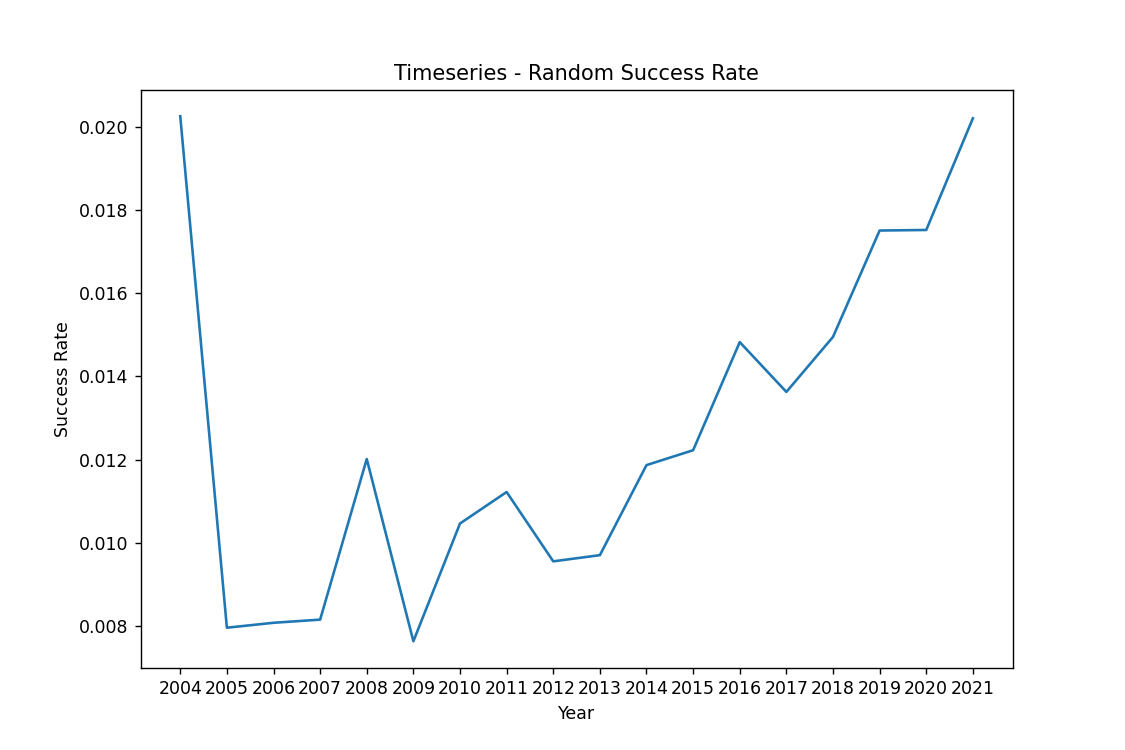

In [21]:
%matplotlib notebook

# Preperation
random_result_df['success_rate'] = random_result_df['successful_transactions']/(random_result_df['successful_transactions'] + random_result_df['failed_transactions'])
random_result_df['year'] = pd.DatetimeIndex(random_result_df['date']).year
random_result_yearly_df = random_result_df.groupby(['year']).mean()

# Data
Xplot = random_result_yearly_df.index
yplot = random_result_yearly_df['success_rate']

# Line Plot
fig, ax = plt.subplots(figsize=(9, 6))
plt.xticks(random_result_yearly_df.index)
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.plot(Xplot, yplot)
plt.title("Timeseries - Random Success Rate")
plt.savefig("visualizations/random_success_rate.svg")
plt.show()

#### Reinforcement learning agent

<IPython.core.display.Javascript object>


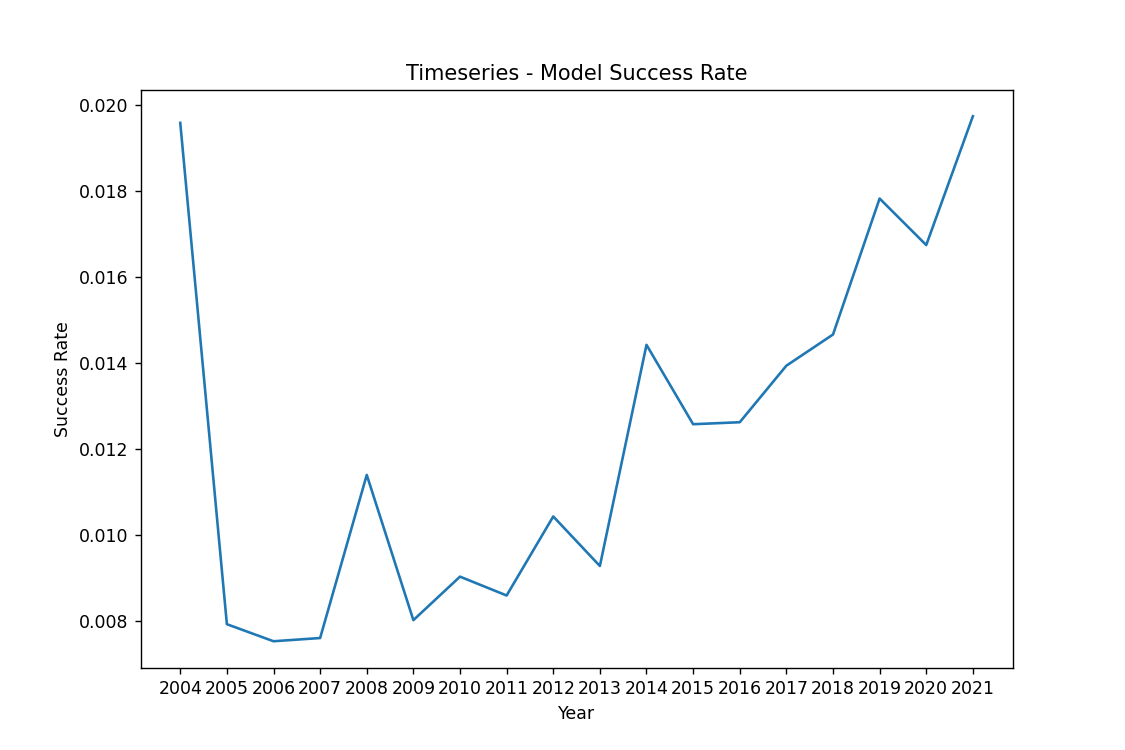

In [22]:
%matplotlib notebook

# Preperation
model_result_df['success_rate'] = model_result_df['successful_transactions']/(model_result_df['successful_transactions'] + model_result_df['failed_transactions'])
model_result_df['year'] = pd.DatetimeIndex(model_result_df['date']).year
model_result_yearly_df = model_result_df.groupby(['year']).mean()

# Data
Xplot = model_result_yearly_df.index
yplot = model_result_yearly_df['success_rate']

# Line Plot
fig, ax = plt.subplots(figsize=(9, 6))
plt.xticks(model_result_yearly_df.index)
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.plot(Xplot, yplot)
plt.title("Timeseries - Model Success Rate")
plt.savefig("visualizations/model_success_rate.svg")
plt.show()

#### Comparison

<IPython.core.display.Javascript object>


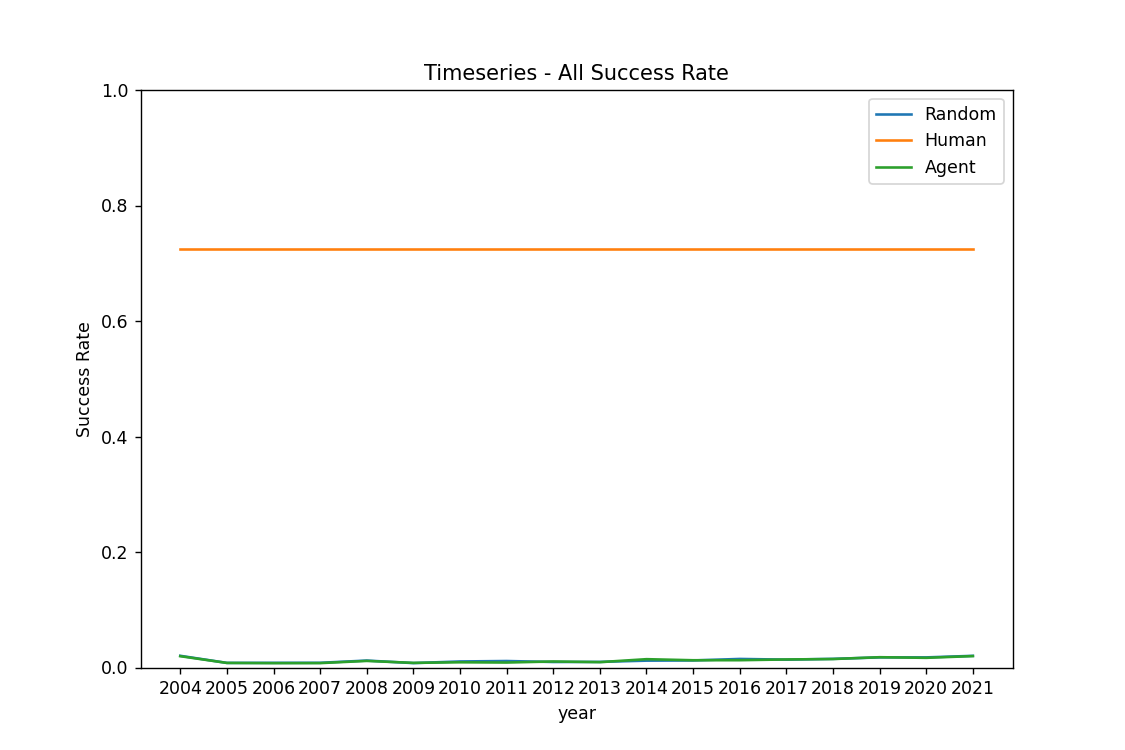

In [23]:
%matplotlib notebook

# Data
Xplot =random_result_yearly_df.index
y1plot = random_result_yearly_df['success_rate']
y2plot = [0.725 for i in range(18)]  # Extracted from the exploration notebook
y3plot = model_result_yearly_df['success_rate']

# Line Plot
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_ylim([0, 1])
plt.xticks(random_result_yearly_df.index)
plt.xlabel("year")
plt.ylabel("Success Rate")
plt.plot(Xplot, y1plot, label="Random")
plt.plot(Xplot, y2plot, label="Human")
plt.plot(Xplot, y3plot, label="Agent")
plt.legend()
plt.title("Timeseries - All Success Rate")
plt.savefig("visualizations/all_success_rate.svg")
plt.show()

### Inventory Snapshots

In [29]:
with open('data/random_snapshots.pkl', 'rb') as infile:
    random_snapshots = pickle.load(infile)
    
with open('data/model_snapshots.pkl', 'rb') as infile:
    model_snapshots = pickle.load(infile)

inventory_df = drugs_df.set_index('pzn')
display(inventory_df)

,bezeichnung,herkue,darr,menge,warengruppe,me,rezeptflichtig,apothekenpflichtig,lagerort
pzn,,,,,,,,,
112,ACALYPHA indica D 3 Globuli,DHU,GLO,10,BX01,G,False,True,X
313,BAMBUSA D 1 Globuli,DHU,GLO,10,BX01,G,False,True,X
460,CHIMAPHILA UMBELLATA D 12 Tabletten,DHU,TAB,80,BX01,ST,False,True,X
1353,ENDOFALK Tropic Plv.z.Her.e.Lsg.z.Einn.Btl.,FALKP,PLE,8,AA06AD65,ST,False,True,X
1382,MYRISTICA SEBIFERA D 3 Dilution,DHU,DIL,20,BX01,ML,False,True,X
...,...,...,...,...,...,...,...,...,...
17445321,IBUPROFEN ADGC 400 mg Filmtabletten,ZENTI,FTA,50,AM01AE01,ST,False,True,X
17502473,PARACETAMOL ADGC 500 mg Tabletten,ZENTI,TAB,10,AN02BE01,ST,False,True,X
17502496,PARACETAMOL ADGC 500 mg Tabletten,ZENTI,TAB,20,AN02BE01,ST,False,True,X


#### Year 2007

In [31]:
human_inventory_2007_series = inventory_dict[2007].set_index('PZN')['Bestand']
random_inventory_2007_series = random_snapshots[datetime.date(2007, 1, 2)]
model_inventory_2007 = model_snapshots[datetime.date(2007, 1, 2)]
inventory_2007 = pd.merge(drugs_df, human_inventory_2007_series, left_on='pzn', right_on='PZN', how='left')
inventory_2007['human_bestand'] = inventory_2007['Bestand']
inventory_2007['model_bestand'] = model_inventory_2007
inventory_2007['random_bestand'] = model_inventory_2007
inventory_2007 = inventory_2007.set_index('pzn')[['bezeichnung', 'lagerort', 'rezeptflichtig', 'apothekenpflichtig', 'human_bestand', 'model_bestand']].fillna(0)
inventory_2007['human_bestand'] = inventory_2007['human_bestand'].astype(int)
display(inventory_2007)

,bezeichnung,lagerort,rezeptflichtig,apothekenpflichtig,human_bestand,model_bestand
pzn,,,,,,
112,ACALYPHA indica D 3 Globuli,X,False,True,0,0
313,BAMBUSA D 1 Globuli,X,False,True,0,0
460,CHIMAPHILA UMBELLATA D 12 Tabletten,X,False,True,0,0
1353,ENDOFALK Tropic Plv.z.Her.e.Lsg.z.Einn.Btl.,X,False,True,0,1
1382,MYRISTICA SEBIFERA D 3 Dilution,X,False,True,0,0
...,...,...,...,...,...,...
17445321,IBUPROFEN ADGC 400 mg Filmtabletten,X,False,True,0,0
17502473,PARACETAMOL ADGC 500 mg Tabletten,X,False,True,0,0
17502496,PARACETAMOL ADGC 500 mg Tabletten,X,False,True,0,0
